## How to use 2D velocity estimate functions

This notebook shows how to use `two_dim_velocity_estimates.py` to get a 2D velocity field for experimental data using a time delay estimation method based on either
- cross correlation 
- cross conditional average 

Documentation on how to generate raw apd dataset: https://github.com/sajidah-ahmed/cmod_functions/blob/main/guides/how_to_use_raw_APD_datatset_function.ipynb

Documentation on xarray can be found here: https://docs.xarray.dev/en/stable/getting-started-guide/quick-overview.html

In [20]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import fppanalysis.two_dim_velocity_estimates as tdve
import cosmoplots

For experimental data:

(Note: Experimental data should be normalized. --> Normalize xarray dataset. Include LCFS and limiter position)

In [32]:
path = Path("/Users/ahe104/Box/mfe_data/raw_apd_data")
shot = 1111208034
ds = xr.open_dataset(str(path) + "/" + f"apd_signal_array_{shot}.nc")

## Cross correlation

`estimate_velocity_field()` will return a class containing estimated velocity data of all pixels

method = 'cross_corr' is set as default

In [16]:
movie_data = tdve.estimate_velocity_field(ds)

Extract estimated velocities and their confidences for each pixel

Confindeces are given as the maximum value of the cross correlation function at which the time lag is computed

In [18]:
vx = movie_data.get_vx()
vy = movie_data.get_vy()
confidences = movie_data.get_confidences()
R = movie_data.get_R()
Z = movie_data.get_Z()

In [19]:
R_coordinates, Z_coordinates = tdve._get_rz_full(ds)

Use quiver to plot the velocity field.

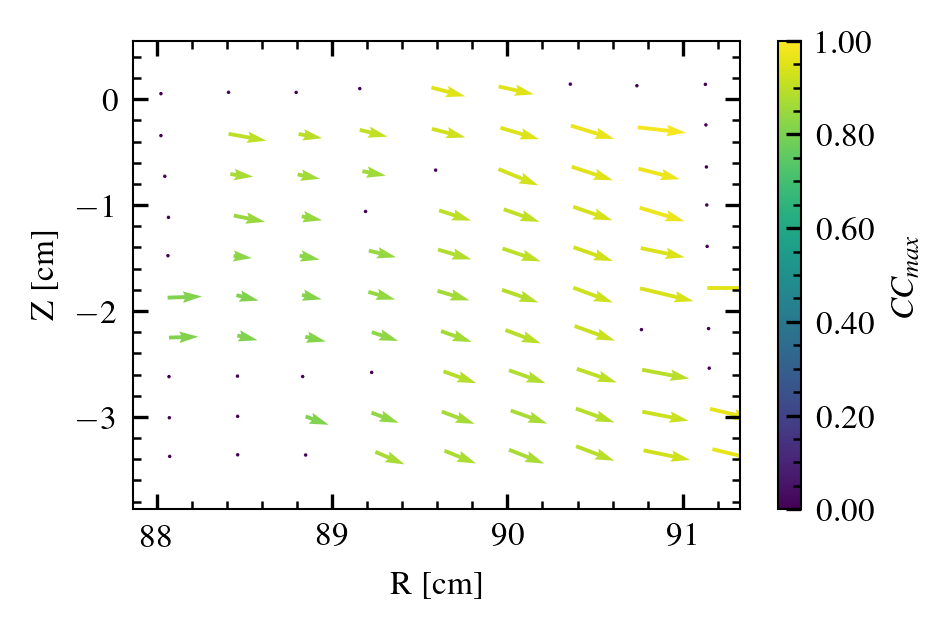

In [25]:
axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
plt.rcParams["mathtext.fontset"] = "custom"

fig = plt.figure()
ax = fig.add_axes(axes_size)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
qiv = ax.quiver(
    R,
    Z,
    vx,
    vy,
    confidences,
    scale=210000,   # Scale arrows
    scale_units="xy",
    angles="xy",
    norm=norm,
)
cbar = fig.colorbar(qiv, format="%.2f")    
cbar.ax.set_ylabel(r"$CC_{max} $")
ax.set_xlabel("R [cm]")
ax.set_ylabel("Z [cm]")
ax.set_ylim(min(Z_coordinates[0]) - 0.5, max(Z_coordinates[0] + 0.5))
plt.show()

## Cross conditional average

To use cross conditional average, the method argument in `estimate_velocity_field()` must be specified as 'cond_av' and the following parameters are necessary

- min_threshold: Lowest threshold for conditional average method
- max_threshold: Maxiumum threshold for conditional average method
- delta: If window = True, delta is the minimal distance between two peaks.
- window: [bool] If True, delta also gives the minimal distance between peaks.

These arguments are sent in as kwargs in the function

In [33]:
method = 'cond_av'
min_threshold = 2.5
max_threshold = np.inf
delta = 1.1e-4
window = True

movie_data = tdve.estimate_velocity_field(
    ds,
    method,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    delta=delta,
    window=window,
)

Extract estimated velocities and their confidences for each pixel

Confidences of the estimation is a value in the interval (0, 1) given by the
cross conditional variance for each event. OBS: We return 1-CV for cross conditional variance.

From conditional averaging we also obtain number of events for each average. This is another variable contained in the class. 

In [34]:
vx = movie_data.get_vx()
vy = movie_data.get_vy()
confidences = movie_data.get_confidences()
R = movie_data.get_R()
Z = movie_data.get_Z()
events = movie_data.get_events()

Use quiver to plot the velocity field. Here, number of events are plotted as the third dimension shown in the colorbar

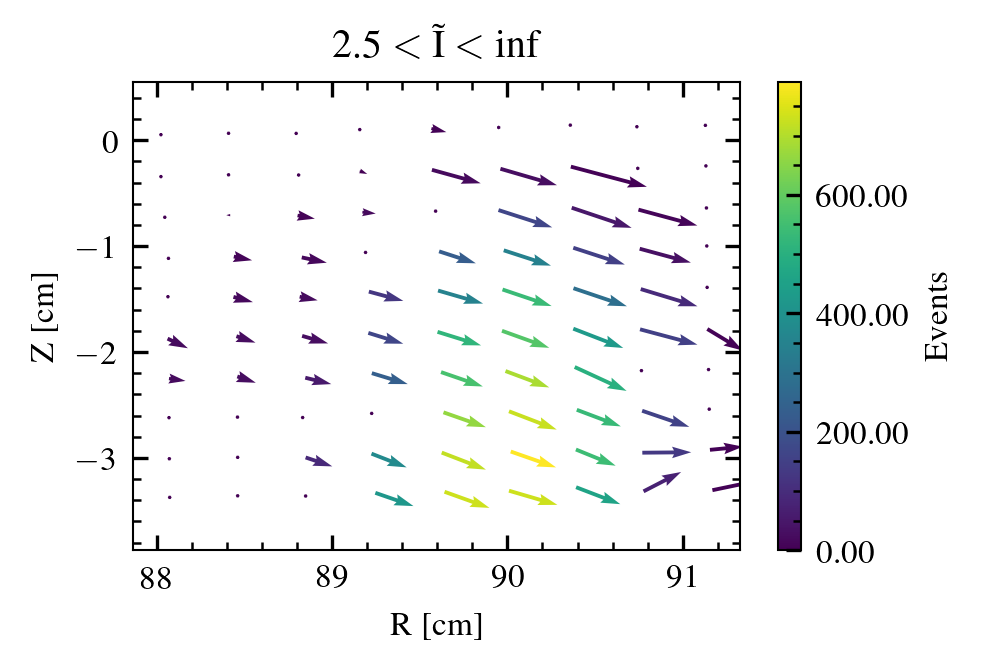

In [35]:
fig = plt.figure()
ax = fig.add_axes(axes_size)

norm = mpl.colors.Normalize(vmin=0, vmax=1500) if shot == 1111208034 else None
qiv = ax.quiver(
    R,
    Z,
    vx,
    vy,
    events,
    scale=210000,
    scale_units="xy",
    angles="xy",
)
cbar = fig.colorbar(qiv, format="%.2f")    
cbar.ax.set_ylabel("Events")
ax.set_xlabel("R [cm]")
ax.set_ylabel("Z [cm]")
ax.set_ylim(min(Z_coordinates[0]) - 0.5, max(Z_coordinates[0] + 0.5))
ax.set_title(
    f"{min_threshold} "
    r"$ < \tilde{\mathrm{I}} < $ "
    f"{max_threshold}"
)
plt.show()